# ResNet50v2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d gpiosenka/100-bird-species

 99% 1.16G/1.17G [00:43<00:00, 23.2MB/s]
100% 1.17G/1.17G [00:43<00:00, 28.9MB/s]


In [ ]:
!unzip 100-bird-species.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: train/TURQUOISE MOTMOT/043.jpg  
  inflating: train/TURQUOISE MOTMOT/044.jpg  
  inflating: train/TURQUOISE MOTMOT/045.jpg  
  inflating: train/TURQUOISE MOTMOT/046.jpg  
  inflating: train/TURQUOISE MOTMOT/047.jpg  
  inflating: train/TURQUOISE MOTMOT/048.jpg  
  inflating: train/TURQUOISE MOTMOT/049.jpg  
  inflating: train/TURQUOISE MOTMOT/050.jpg  
  inflating: train/TURQUOISE MOTMOT/051.jpg  
  inflating: train/TURQUOISE MOTMOT/052.jpg  
  inflating: train/TURQUOISE MOTMOT/053.jpg  
  inflating: train/TURQUOISE MOTMOT/054.jpg  
  inflating: train/TURQUOISE MOTMOT/055.jpg  
  inflating: train/TURQUOISE MOTMOT/056.jpg  
  inflating: train/TURQUOISE MOTMOT/057.jpg  
  inflating: train/TURQUOISE MOTMOT/058.jpg  
  inflating: train/TURQUOISE MOTMOT/059.jpg  
  inflating: train/TURQUOISE MOTMOT/060.jpg  
  inflating: train/TURQUOISE MOTMOT/061.jpg  
  inflating: train/TURQUOISE MOTMOT/062.jpg  
  inflating: train/TURQUOISE M

Distractor:

In [ ]:
!unzip -q '/content/drive/My Drive/CV_Birds/mirflickr.zip' -d '/content'

## Dataset creation
Here all the dataset needed are created:

In [ ]:
import tensorflow as tf

In [ ]:
TRAIN_DIR = 'train/'
VALID_DIR = 'valid/'
TEST_DIR = 'test/'
DISTRACTOR_DIR = 'mirflickr'
BATCH_SIZE = 128
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
RANDOM_SEED = 42

In [ ]:
training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=False, seed=RANDOM_SEED, interpolation='bilinear')

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=False, seed=RANDOM_SEED, interpolation='bilinear')

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VALID_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=False, seed=RANDOM_SEED, interpolation='bilinear')

Found 47332 files belonging to 325 classes.
Found 1625 files belonging to 325 classes.
Found 1625 files belonging to 325 classes.


In [ ]:
NUM_CLASSES = len(training_images.class_names)

In [ ]:
distractor_images = tf.keras.preprocessing.image_dataset_from_directory(
    DISTRACTOR_DIR,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE,
    seed=RANDOM_SEED,
    labels=None,
    label_mode=None)

Found 25000 files belonging to 1 classes.


## Utils for plotting

In [ ]:
def plot_model(model, model_name):
    ks.utils.plot_model(model, model_name, show_shapes=True)

def plot_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(range(1, len(acc) + 1), acc, 'r', label='Training Accuracy')
    plt.plot(range(1, len(acc) + 1), val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.plot()

def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(range(1, len(loss) + 1), loss, 'r', label='Training Loss')
    plt.plot(range(1, len(loss) + 1), val_loss, 'g', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.plot()

## ResNet50 Class

Needed imports:

In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import regularizers
import pathlib
import matplotlib.pyplot as plt
import numpy as np

Data augmentation object

In [ ]:
data_augmentation = ks.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1)
    ]
)

The following cells contains function usedful for the creation of all the tested models later proposed:

In [ ]:
def input(data_augmentation=None):
    inputs = ks.Input(shape=(224, 224, 3))
    x = ks.applications.resnet50.preprocess_input(inputs)
    if data_augmentation is not None:
        x = data_augmentation(x)
    return x

In [ ]:
def base_resnet50v2():
    res = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=((224, 224, 3)),
        pooling='avg'
    )
    res.trainable = False
    return res

In [ ]:
def fine_tuning(num_of_blocks=1):
    if num_of_blocks < 1:
        num_of_blocks = 1

    res = base_resnet50v2()
    res.trainable = True
    set_trainable = False

    if num_of_blocks == 1:
        block_name = 'conv5_block2_out'
    elif num_of_blocks == 2:
        block_name = 'conv5_block1_out'
    elif num_of_blocks == 3:
        block_name = 'conv4_block6_out'
    elif num_of_blocks == 4:
        block_name = 'conv4_block5_out'
    elif num_of_blocks == 5:
        block_name = 'conv4_block4_out'
    elif num_of_blocks == 6:
        block_name = 'conv4_block3_out'
    else:
        block_name = 'conv4_block2_out'

    for layer in res.layers:
        if layer.name == block_name:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    return res

### ResNet50 Feature extraction

In [ ]:
def resnet50_feature_extraction(data_augmentation=None):
    inputs = input(data_augmentation)
    outputs = base_resnet50v2()(inputs)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = resnet50_feature_extraction()

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
features = resnet50_feature_extraction().predict(training_images, batch_size=BATCH_SIZE, verbose=True)

370/370 [==============================] - 263s 672ms/step


In [ ]:
features.shape

(47332, 2048)

Save features:

In [ ]:
np.save('/content/drive/MyDrive/CV_Birds/features/training/ResNet50v2/resnet50_fe_features.npy', features)

Features for test set:

In [ ]:
features = model.predict(test_images, batch_size=BATCH_SIZE, verbose=True)

13/13 [==============================] - 12s 935ms/step


In [ ]:
np.save('/content/drive/MyDrive/CV_Birds/features/test/ResNet50v2/resnet50_fe_features.npy', features)

Features for distractor set:

In [ ]:
features = model.predict(distractor_images, batch_size=BATCH_SIZE, verbose=True)

196/196 [==============================] - 139s 675ms/step


In [ ]:
np.save('/content/drive/MyDrive/CV_Birds/features/distractor/ResNet50v2/resnet50_fe_features.npy', features)

### Predictions

In [ ]:
def resnet50_feature_extraction_pred(num_classes, data_augmentation=None):
    inputs = input(data_augmentation)
    x = base_resnet50v2()(inputs)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model1.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model = resnet50_feature_extraction_pred(NUM_CLASSES, data_augmentation=data_augmentation)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 predictions (Dense)         (None, 325)               665925    
                                                                 
Total params: 24,230,725
Trainable params: 665,925
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
model.layers[0]

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model.fit(
    training_images,
    epochs=25,
    verbose=True,
    callbacks=callbacks_list,
    validation_data=val_images,
    batch_size=BATCH_SIZE
)

Epoch 1/25
370/370 [==============================] - ETA: 0s - loss: 331.7132 - accuracy: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 308s 792ms/step - loss: 331.7132 - accuracy: 0.0000e+00 - val_loss: 385.4302 - val_accuracy: 0.0055
Epoch 2/25
370/370 [==============================] - 283s 766ms/step - loss: 360.8794 - accuracy: 0.0000e+00 - val_loss: 390.1001 - val_accuracy: 0.0037
Epoch 3/25
 47/370 [==>...........................] - ETA: 4:01 - loss: 362.2411 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored

Plotting loss and accuracy:

In [ ]:
plot_accuracy(history)

In [ ]:
plot_loss(history)

Evaluating on test set:

## Model 1: Fine tuning from block4_conv5_out

In [ ]:
def finetuned_resnet50(num_classes, num_of_blocks=1, data_augmentation=None):
    inputs = input(data_augmentation)
    x = fine_tuning(num_of_blocks=num_of_blocks)(inputs)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model1.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model1 = finetuned_resnet50(NUM_CLASSES, num_of_blocks=4, data_augmentation=data_augmentation)
model1.summary()

94683136/94668760 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 predictions (Dense)         (None, 325)               665925    
                                                                 
Total params: 24,230,725
Trainable params: 16,755,013
Non-trainable params: 7,475,712
_________________________________________________________________


In [ ]:
model1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model1.fit(
    training_images,
    epochs=40,
    verbose=True,
    callbacks=callbacks_list,
    validation_data=val_images,
    batch_size=BATCH_SIZE
)

Epoch 1/40
370/370 [==============================] - ETA: 0s - loss: 3.6477 - accuracy: 0.2353

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 411s 1s/step - loss: 3.6477 - accuracy: 0.2353 - val_loss: 2.2429 - val_accuracy: 0.4775
Epoch 2/40
370/370 [==============================] - 384s 1s/step - loss: 1.6534 - accuracy: 0.5907 - val_loss: 1.2442 - val_accuracy: 0.6898
Epoch 3/40
370/370 [==============================] - 384s 1s/step - loss: 0.9411 - accuracy: 0.7541 - val_loss: 0.9248 - val_accuracy: 0.7563
Epoch 4/40
370/370 [==============================] - 382s 1s/step - loss: 0.4989 - accuracy: 0.8661 - val_loss: 0.9938 - val_accuracy: 0.7477
Epoch 5/40
370/370 [==============================] - 384s 1s/step - loss: 0.2468 - accuracy: 0.9349 - val_loss: 0.9020 - val_accuracy: 0.7742
Epoch 6/40
370/370 [==============================] - 384s 1s/step - loss: 0.1330 - accuracy: 0.9671 - val_loss: 0.8868 - val_accuracy: 0.7742
Epoch 7/40
370/370 [==============================] - 383s 1s/step - loss: 0.0894 - accuracy: 0.9793 - val_loss: 0.8794 - val_accuracy: 0.7852
Epoch 8/40

Plotting loss and accuracy:

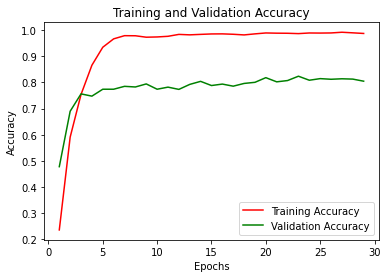

In [ ]:
plot_accuracy(history)

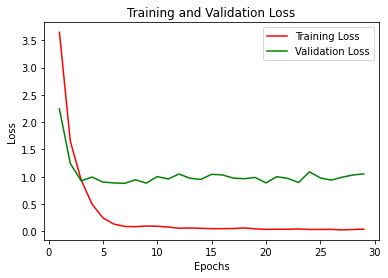

In [ ]:
plot_loss(history)

Evaluating on test set:

In [ ]:
model1.evaluate(test_images)

13/13 [==============================] - 10s 734ms/step - loss: 0.7162 - accuracy: 0.8388


[0.7161863446235657, 0.838769257068634]

Save model:

In [ ]:
ks.models.save_model(model1, 'model1.keras')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Model 2: Finetuning the entire fifth block

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model2.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model2 = finetuned_resnet50(NUM_CLASSES, num_of_blocks=3, data_augmentation=data_augmentation)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 predictions (Dense)         (None, 325)               665925    
                                                                 
Total params: 24,230,725
Trainable params: 15,636,805
Non-trainable params: 8,593,920
_________________________________________________________________


In [ ]:
model2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model2.fit(
    training_images,
    epochs=35,
    verbose=True,
    callbacks=callbacks_list,
    validation_data=val_images,
    batch_size=BATCH_SIZE
)

Epoch 1/35
370/370 [==============================] - ETA: 0s - loss: 4.4763 - accuracy: 0.1113

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 452s 1s/step - loss: 4.4763 - accuracy: 0.1113 - val_loss: 3.5007 - val_accuracy: 0.2548
Epoch 2/35
370/370 [==============================] - 446s 1s/step - loss: 2.3619 - accuracy: 0.4388 - val_loss: 1.7113 - val_accuracy: 0.5698
Epoch 3/35
370/370 [==============================] - 446s 1s/step - loss: 1.4918 - accuracy: 0.6288 - val_loss: 1.2323 - val_accuracy: 0.6812
Epoch 4/35
370/370 [==============================] - 446s 1s/step - loss: 0.9712 - accuracy: 0.7492 - val_loss: 1.2121 - val_accuracy: 0.6868
Epoch 5/35
370/370 [==============================] - 446s 1s/step - loss: 0.6031 - accuracy: 0.8431 - val_loss: 1.0374 - val_accuracy: 0.7268
Epoch 6/35
370/370 [==============================] - 446s 1s/step - loss: 0.3407 - accuracy: 0.9125 - val_loss: 0.9477 - val_accuracy: 0.7618
Epoch 7/35
370/370 [==============================] - 445s 1s/step - loss: 0.1761 - accuracy: 0.9580 - val_loss: 1.1296 - val_accuracy: 0.7348
Epoch 8/35

Plotting loss and accuracy:

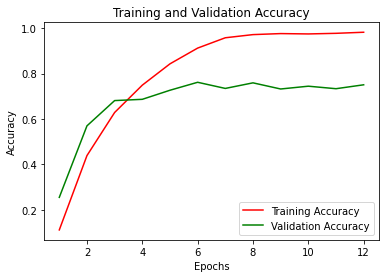

In [ ]:
plot_accuracy(history)

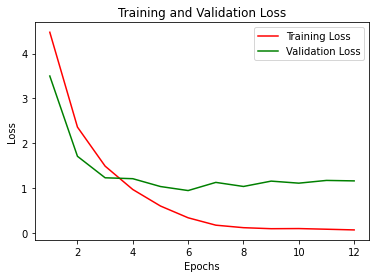

In [ ]:
plot_loss(history)

Evaluating on test set:

In [ ]:
model2.evaluate(test_images)

13/13 [==============================] - 12s 891ms/step - loss: 0.7805 - accuracy: 0.7840


[0.7805495858192444, 0.7839999794960022]

Save model:

In [ ]:
ks.models.save_model(model2, 'model2.keras')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Model 3: Finetuning 1 block

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/CV_Birds/models/model3.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model3 = finetuned_resnet50(NUM_CLASSES, 1, data_augmentation)
model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 predictions (Dense)         (None, 325)               665925    
                                                                 
Total params: 24,230,725
Trainable params: 5,134,661
Non-trainable params: 19,096,064
_________________________________________________________________


In [ ]:
model3.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model3.fit(
    training_images,
    epochs=60,
    verbose=True,
    callbacks=callbacks_list,
    validation_data=val_images,
    batch_size=BATCH_SIZE
)

Epoch 1/60
370/370 [==============================] - ETA: 0s - loss: 4.4275 - accuracy: 0.1324

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 334s 853ms/step - loss: 4.4275 - accuracy: 0.1324 - val_loss: 3.1834 - val_accuracy: 0.3009
Epoch 2/60
370/370 [==============================] - 309s 832ms/step - loss: 2.7871 - accuracy: 0.3663 - val_loss: 2.1667 - val_accuracy: 0.4923
Epoch 3/60
370/370 [==============================] - 309s 832ms/step - loss: 2.0669 - accuracy: 0.5098 - val_loss: 1.7396 - val_accuracy: 0.5834
Epoch 4/60
370/370 [==============================] - 312s 840ms/step - loss: 1.5977 - accuracy: 0.6140 - val_loss: 1.5272 - val_accuracy: 0.6289
Epoch 5/60
370/370 [==============================] - 310s 835ms/step - loss: 1.2304 - accuracy: 0.6985 - val_loss: 1.4540 - val_accuracy: 0.6480
Epoch 6/60
370/370 [==============================] - 310s 836ms/step - loss: 0.9297 - accuracy: 0.7725 - val_loss: 1.3954 - val_accuracy: 0.6628
Epoch 7/60
370/370 [==============================] - 312s 840ms/step - loss: 0.6659 - accuracy: 0.8422 - val_loss: 1.3268 - val_accura

Plotting loss and accuracy:

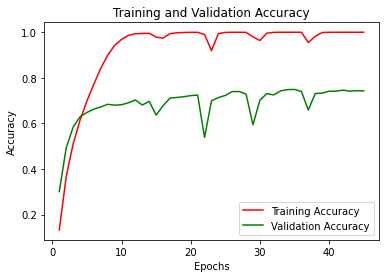

In [ ]:
plot_accuracy(history)

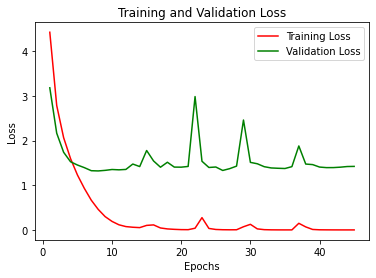

In [ ]:
plot_loss(history)

Evaluating on test set:

In [ ]:
model3.evaluate(test_images)

13/13 [==============================] - 10s 750ms/step - loss: 1.1639 - accuracy: 0.7612


[1.1639214754104614, 0.7612307667732239]

Save model:

In [ ]:
ks.models.save_model(model3, 'model3.keras')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Model 4: Finetuning 2 blocks

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model4.keras',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model4 = finetuned_resnet50(NUM_CLASSES, 2, data_augmentation)
model4.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 predictions (Dense)         (None, 325)               665925    
                                                                 
Total params: 24,230,725
Trainable params: 9,599,301
Non-trainable params: 14,631,424
_________________________________________________________________


In [ ]:
model4.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model4.fit(
    training_images,
    epochs=35,
    verbose=True,
    callbacks=callbacks_list,
    validation_data=val_images,
    batch_size=BATCH_SIZE
)

Epoch 1/35
370/370 [==============================] - ETA: 0s - loss: 4.0693 - accuracy: 0.1771

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 354s 907ms/step - loss: 4.0693 - accuracy: 0.1771 - val_loss: 2.6033 - val_accuracy: 0.3969
Epoch 2/35
370/370 [==============================] - 329s 886ms/step - loss: 2.2929 - accuracy: 0.4604 - val_loss: 1.7173 - val_accuracy: 0.5834
Epoch 3/35
370/370 [==============================] - 329s 886ms/step - loss: 1.5221 - accuracy: 0.6263 - val_loss: 1.3958 - val_accuracy: 0.6505
Epoch 4/35
370/370 [==============================] - 327s 882ms/step - loss: 0.9891 - accuracy: 0.7534 - val_loss: 1.2490 - val_accuracy: 0.6831
Epoch 5/35
370/370 [==============================] - 327s 882ms/step - loss: 0.5745 - accuracy: 0.8598 - val_loss: 1.2419 - val_accuracy: 0.6978
Epoch 6/35
370/370 [==============================] - 326s 879ms/step - loss: 0.2897 - accuracy: 0.9371 - val_loss: 1.3229 - val_accuracy: 0.7034
Epoch 7/35
370/370 [==============================] - 327s 882ms/step - loss: 0.1322 - accuracy: 0.9769 - val_loss: 1.2536 - val_accura

Plotting loss and accuracy:

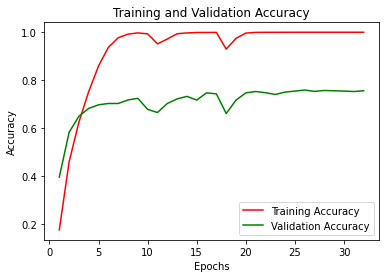

In [ ]:
plot_accuracy(history)

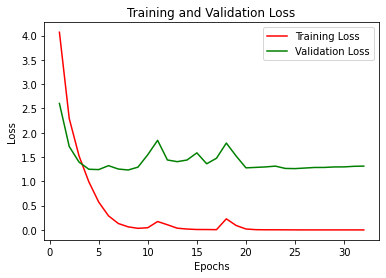

In [ ]:
plot_loss(history)

Evaluating on test set:

In [ ]:
model4.evaluate(test_images)

13/13 [==============================] - 10s 736ms/step - loss: 1.0885 - accuracy: 0.7840


[1.0884628295898438, 0.7839999794960022]

In [ ]:
ks.models.save_model(model4, 'model4.keras')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Model 5: Finetuning 1 block + dense

In [ ]:
def finetuned_resnet50_with_1dense(num_classes, num_of_blocks=1, data_augmentation=None):
    inputs = input(data_augmentation)
    x = fine_tuning(num_of_blocks=num_of_blocks)(inputs)
    x = layers.Dense(1024, activation='relu', name='my_dense1')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model5.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model5 = finetuned_resnet50_with_1dense(NUM_CLASSES, 1, data_augmentation)

94683136/94668760 [==============================] - 3s 0us/step


In [ ]:
model5.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model5.fit(
    training_images,
    epochs=35,
    verbose=True,
    callbacks=callbacks_list,
    validation_data=val_images,
    batch_size=BATCH_SIZE
)

Epoch 1/35
370/370 [==============================] - ETA: 0s - loss: 4.4008 - accuracy: 0.1170

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 336s 856ms/step - loss: 4.4008 - accuracy: 0.1170 - val_loss: 3.1983 - val_accuracy: 0.2855
Epoch 2/35
370/370 [==============================] - 310s 835ms/step - loss: 2.9078 - accuracy: 0.3275 - val_loss: 2.2118 - val_accuracy: 0.4683
Epoch 3/35
370/370 [==============================] - 310s 836ms/step - loss: 2.2005 - accuracy: 0.4673 - val_loss: 1.8144 - val_accuracy: 0.5317
Epoch 4/35
370/370 [==============================] - 310s 836ms/step - loss: 1.7121 - accuracy: 0.5689 - val_loss: 1.5761 - val_accuracy: 0.5902
Epoch 5/35
370/370 [==============================] - 309s 833ms/step - loss: 1.3287 - accuracy: 0.6570 - val_loss: 1.4769 - val_accuracy: 0.6240
Epoch 6/35
370/370 [==============================] - 311s 838ms/step - loss: 1.0054 - accuracy: 0.7324 - val_loss: 1.4855 - val_accuracy: 0.6240
Epoch 7/35
370/370 [==============================] - 311s 837ms/step - loss: 0.7224 - accuracy: 0.8062 - val_loss: 1.5171 - val_accura

Plotting loss and accuracy:

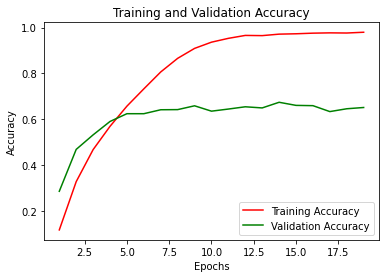

In [ ]:
plot_accuracy(history)

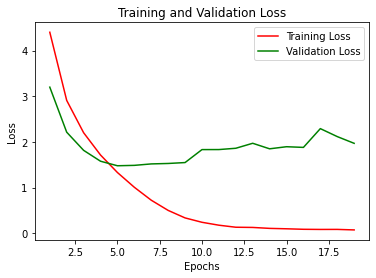

In [ ]:
plot_loss(history)

Evaluating on test set:

In [ ]:
model5.evaluate(test_images)

13/13 [==============================] - 10s 755ms/step - loss: 1.5763 - accuracy: 0.6825


[1.5762619972229004, 0.6824615597724915]

Save model:

In [ ]:
ks.models.save_model(model5, 'model5.keras')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Model 6: Finetuning 2 block + dense

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model6.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model6 = finetuned_resnet50_with_1dense(NUM_CLASSES, 2, data_augmentation)

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
model6.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model6.fit(
    training_images,
    epochs=35,
    verbose=True,
    callbacks=callbacks_list,
    validation_data=val_images,
    batch_size=BATCH_SIZE
)

Epoch 1/35
370/370 [==============================] - ETA: 0s - loss: 4.1386 - accuracy: 0.1516

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 335s 856ms/step - loss: 4.1386 - accuracy: 0.1516 - val_loss: 2.7915 - val_accuracy: 0.3329
Epoch 2/35
370/370 [==============================] - 311s 838ms/step - loss: 2.4749 - accuracy: 0.4095 - val_loss: 1.8768 - val_accuracy: 0.5323
Epoch 3/35
370/370 [==============================] - 312s 841ms/step - loss: 1.6955 - accuracy: 0.5728 - val_loss: 1.6160 - val_accuracy: 0.5877
Epoch 4/35
370/370 [==============================] - 311s 837ms/step - loss: 1.1329 - accuracy: 0.6993 - val_loss: 1.5163 - val_accuracy: 0.6160
Epoch 5/35
370/370 [==============================] - 311s 839ms/step - loss: 0.7067 - accuracy: 0.8051 - val_loss: 1.4899 - val_accuracy: 0.6302
Epoch 6/35
370/370 [==============================] - 310s 836ms/step - loss: 0.4106 - accuracy: 0.8823 - val_loss: 1.6437 - val_accuracy: 0.6388
Epoch 7/35
370/370 [==============================] - 310s 835ms/step - loss: 0.2453 - accuracy: 0.9292 - val_loss: 1.7290 - val_accura

Plotting loss and accuracy:

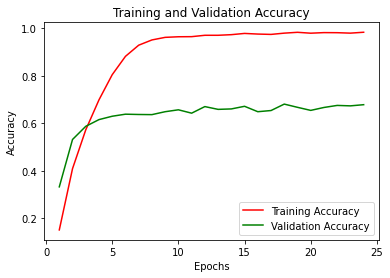

In [ ]:
plot_accuracy(history)

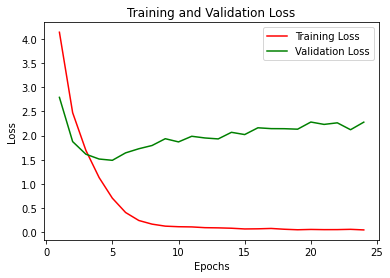

In [ ]:
plot_loss(history)

Evaluating on test set:

In [ ]:
model6.evaluate(test_images)

13/13 [==============================] - 9s 692ms/step - loss: 1.7966 - accuracy: 0.6769


[1.7966245412826538, 0.6769230961799622]

Save model:

In [ ]:
ks.models.save_model(model6, 'model6.keras')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Model 7: Finetuning 1 block + 2 denses

In [ ]:
def finetuned_resnet50_with_2denses(num_classes, num_of_blocks=1, data_augmentation=None):
    inputs = input(data_augmentation)
    x = fine_tuning(num_of_blocks=num_of_blocks)(inputs)
    x = layers.Dense(1024, activation='relu', name='my_dense1')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu', name='my_dense2')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model7.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model7 = finetuned_resnet50_with_2denses(NUM_CLASSES, 1, data_augmentation)

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
model7.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model7.fit(
    training_images,
    epochs=35,
    verbose=True,
    callbacks=callbacks_list,
    validation_data=val_images,
    batch_size=BATCH_SIZE
)

Epoch 1/35
370/370 [==============================] - ETA: 0s - loss: 4.7952 - accuracy: 0.0634

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 311s 792ms/step - loss: 4.7952 - accuracy: 0.0634 - val_loss: 3.7540 - val_accuracy: 0.1643
Epoch 2/35
370/370 [==============================] - 287s 772ms/step - loss: 3.5910 - accuracy: 0.1923 - val_loss: 2.7770 - val_accuracy: 0.3188
Epoch 3/35
370/370 [==============================] - 286s 771ms/step - loss: 3.0062 - accuracy: 0.2901 - val_loss: 2.3489 - val_accuracy: 0.4185
Epoch 4/35
370/370 [==============================] - 286s 772ms/step - loss: 2.5804 - accuracy: 0.3696 - val_loss: 2.0187 - val_accuracy: 0.4855
Epoch 5/35
370/370 [==============================] - 286s 771ms/step - loss: 2.2349 - accuracy: 0.4389 - val_loss: 1.8709 - val_accuracy: 0.5243
Epoch 6/35
370/370 [==============================] - 286s 770ms/step - loss: 1.9346 - accuracy: 0.4992 - val_loss: 1.7219 - val_accuracy: 0.5575
Epoch 7/35
370/370 [==============================] - 286s 771ms/step - loss: 1.6587 - accuracy: 0.5597 - val_loss: 1.6523 - val_accura

Plotting loss and accuracy:

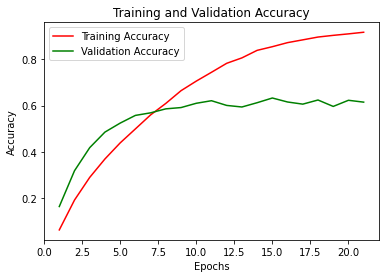

In [ ]:
plot_accuracy(history)

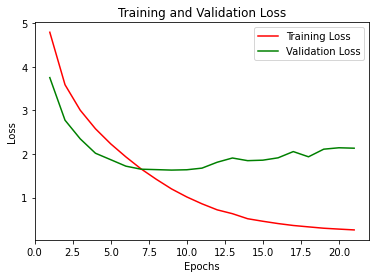

In [ ]:
plot_loss(history)

Evaluating on test set:

In [ ]:
model7.evaluate(test_images)

13/13 [==============================] - 9s 688ms/step - loss: 1.6871 - accuracy: 0.6474


[1.6870516538619995, 0.6473846435546875]

Save model:

In [ ]:
ks.models.save_model(model7, 'model7.keras')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Model 8: Finetuning 2 blocks + 2 denses

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model8.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model8 = finetuned_resnet50_with_2denses(NUM_CLASSES, 2, data_augmentation)

In [ ]:
model8.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model8.fit(
    training_images,
    epochs=35,
    verbose=True,
    callbacks=callbacks_list,
    validation_data=val_images,
    batch_size=BATCH_SIZE
)

Epoch 1/35
370/370 [==============================] - ETA: 0s - loss: 4.6818 - accuracy: 0.0736

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 313s 834ms/step - loss: 4.6818 - accuracy: 0.0736 - val_loss: 3.5162 - val_accuracy: 0.1963
Epoch 2/35
370/370 [==============================] - 309s 833ms/step - loss: 3.3330 - accuracy: 0.2278 - val_loss: 2.5151 - val_accuracy: 0.3834
Epoch 3/35
370/370 [==============================] - 309s 832ms/step - loss: 2.6477 - accuracy: 0.3524 - val_loss: 2.1098 - val_accuracy: 0.4646
Epoch 4/35
370/370 [==============================] - 309s 834ms/step - loss: 2.1320 - accuracy: 0.4573 - val_loss: 1.7283 - val_accuracy: 0.5582
Epoch 5/35
370/370 [==============================] - 308s 830ms/step - loss: 1.6928 - accuracy: 0.5508 - val_loss: 1.7320 - val_accuracy: 0.5563
Epoch 6/35
370/370 [==============================] - 309s 833ms/step - loss: 1.3214 - accuracy: 0.6326 - val_loss: 1.6499 - val_accuracy: 0.5914
Epoch 7/35
370/370 [==============================] - 308s 829ms/step - loss: 1.0314 - accuracy: 0.7001 - val_loss: 1.6981 - val_accura

Plotting loss and accuracy:

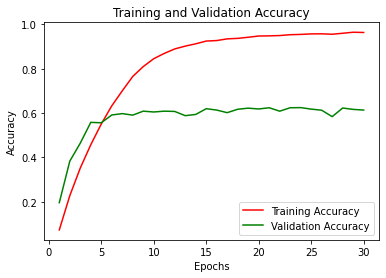

In [ ]:
plot_accuracy(history)

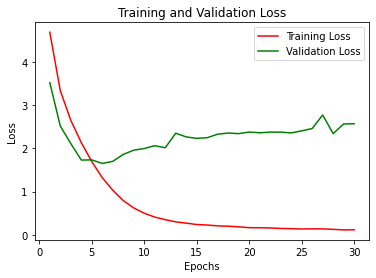

In [ ]:
plot_loss(history)

Evaluating on test set:

In [ ]:
model8.evaluate(test_images)

13/13 [==============================] - 9s 692ms/step - loss: 2.1074 - accuracy: 0.6289


[2.107438325881958, 0.6289230585098267]

Save model

In [ ]:
ks.models.save_model(model8, 'model8.keras')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Model 9: Finetuning from conv4_block4_out

In [ ]:
def finetuned_resnet50(num_classes, num_of_blocks=1, data_augmentation=None):
    inputs = input(data_augmentation)
    x = fine_tuning(num_of_blocks=num_of_blocks)(inputs)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model9.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model9 = finetuned_resnet50(NUM_CLASSES, 5, data_augmentation)
model9.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 predictions (Dense)         (None, 325)               665925    
                                                                 
Total params: 24,230,725
Trainable params: 17,873,221
Non-trainable params: 6,357,504
_________________________________________________________________


In [ ]:
model9.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model9.fit(
    training_images,
    epochs=40,
    verbose=True,
    callbacks=callbacks_list,
    validation_data=val_images,
    batch_size=BATCH_SIZE
)

Epoch 1/40
370/370 [==============================] - ETA: 0s - loss: 2.8494 - accuracy: 0.3520

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 412s 1s/step - loss: 2.8494 - accuracy: 0.3520 - val_loss: 1.7642 - val_accuracy: 0.5526
Epoch 2/40
370/370 [==============================] - 397s 1s/step - loss: 1.3830 - accuracy: 0.6547 - val_loss: 1.0358 - val_accuracy: 0.7243
Epoch 3/40
370/370 [==============================] - 393s 1s/step - loss: 0.7429 - accuracy: 0.8038 - val_loss: 0.9339 - val_accuracy: 0.7600
Epoch 4/40
370/370 [==============================] - 394s 1s/step - loss: 0.3669 - accuracy: 0.9034 - val_loss: 0.9192 - val_accuracy: 0.7557
Epoch 5/40
370/370 [==============================] - 395s 1s/step - loss: 0.1617 - accuracy: 0.9606 - val_loss: 0.8818 - val_accuracy: 0.7729
Epoch 6/40
370/370 [==============================] - 394s 1s/step - loss: 0.0932 - accuracy: 0.9790 - val_loss: 0.8231 - val_accuracy: 0.7877
Epoch 7/40
370/370 [==============================] - 393s 1s/step - loss: 0.0788 - accuracy: 0.9807 - val_loss: 0.8407 - val_accuracy: 0.7926
Epoch 8/40

Plotting loss and accuracy:

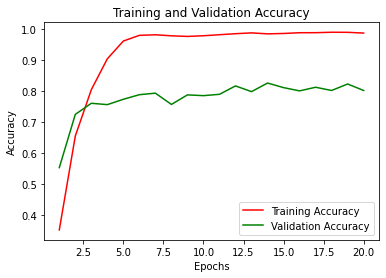

In [ ]:
plot_accuracy(history)

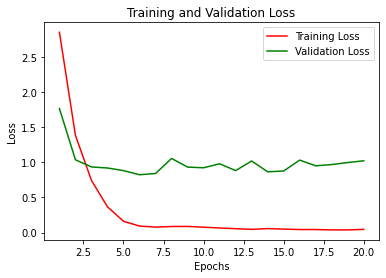

In [ ]:
plot_loss(history)

Evaluating on test set:

In [ ]:
model9.evaluate(test_images)

13/13 [==============================] - 9s 703ms/step - loss: 0.6962 - accuracy: 0.8332


[0.6961840987205505, 0.8332307934761047]

Save model

In [ ]:
ks.models.save_model(model9, 'model9.keras')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Model 10: Finetuning from conv4_block3_out


In [ ]:
def finetuned_resnet50(num_classes, num_of_blocks=1, data_augmentation=None):
    inputs = input(data_augmentation)
    x = fine_tuning(num_of_blocks=num_of_blocks)(inputs)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model10.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model10 = finetuned_resnet50(NUM_CLASSES, 6, data_augmentation)
model10.summary()

94683136/94668760 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 predictions (Dense)         (None, 325)               665925    
                                                                 
Total params: 24,230,725
Trainable params: 18,991,429
Non-trainable params: 5,239,296
_________________________________________________________________


In [ ]:
model10.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model10.fit(
    training_images,
    epochs=40,
    verbose=True,
    callbacks=callbacks_list,
    validation_data=val_images,
    batch_size=BATCH_SIZE
)

Epoch 1/40
370/370 [==============================] - ETA: 0s - loss: 3.5249 - accuracy: 0.2579

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


370/370 [==============================] - 245s 611ms/step - loss: 3.5249 - accuracy: 0.2579 - val_loss: 2.0005 - val_accuracy: 0.5225
Epoch 2/40
370/370 [==============================] - 223s 600ms/step - loss: 1.5228 - accuracy: 0.6246 - val_loss: 1.1338 - val_accuracy: 0.7114
Epoch 3/40
370/370 [==============================] - 222s 599ms/step - loss: 0.8197 - accuracy: 0.7865 - val_loss: 0.9069 - val_accuracy: 0.7600
Epoch 4/40
370/370 [==============================] - 222s 598ms/step - loss: 0.4077 - accuracy: 0.8923 - val_loss: 0.8302 - val_accuracy: 0.7932
Epoch 5/40
370/370 [==============================] - 221s 596ms/step - loss: 0.1873 - accuracy: 0.9534 - val_loss: 0.8329 - val_accuracy: 0.7938
Epoch 6/40
370/370 [==============================] - 222s 599ms/step - loss: 0.1058 - accuracy: 0.9751 - val_loss: 0.8098 - val_accuracy: 0.8000
Epoch 7/40
370/370 [==============================] - 221s 596ms/step - loss: 0.0768 - accuracy: 0.9815 - val_loss: 0.8587 - val_accura

Plotting loss and accuracy:

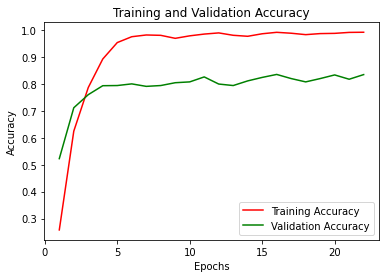

In [ ]:
plot_accuracy(history)

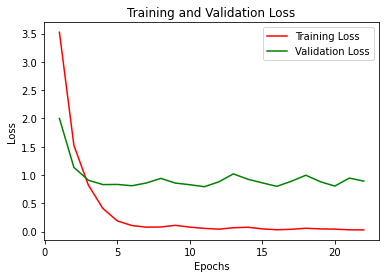

In [ ]:
plot_loss(history)

Evaluating on test set:

In [ ]:
model10.evaluate(test_images)

13/13 [==============================] - 5s 387ms/step - loss: 0.5360 - accuracy: 0.8720


[0.5359786748886108, 0.871999979019165]

Save model

In [ ]:
ks.models.save_model(model10, 'model10.keras')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Model 11: Finetuning from conv4_block2_out


In [ ]:
def finetuned_resnet50(num_classes, num_of_blocks=1, data_augmentation=None):
    inputs = input(data_augmentation)
    x = fine_tuning(num_of_blocks=num_of_blocks)(inputs)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    model = ks.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='model11.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

In [ ]:
model11 = finetuned_resnet50(NUM_CLASSES, 7, data_augmentation)
model11.summary()

94683136/94668760 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 predictions (Dense)         (None, 325)               665925    
                                                                 
Total params: 24,230,725
Trainable params: 18,991,429
Non-trainable params: 5,239,296
_________________________________________________________________


In [ ]:
model11.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

history = model11.fit(
    training_images,
    epochs=40,
    verbose=True,
    callbacks=callbacks_list,
    validation_data=val_images,
    batch_size=BATCH_SIZE
)

Plotting loss and accuracy:

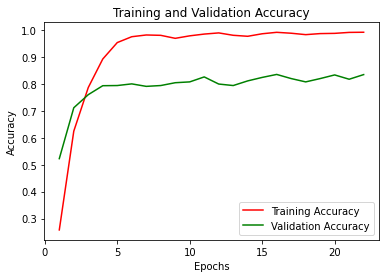

In [ ]:
plot_accuracy(history)

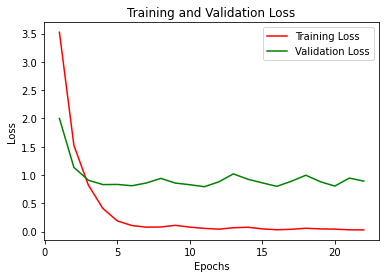

In [ ]:
plot_loss(history)

Evaluating on test set:

In [ ]:
model11.evaluate(test_images)

13/13 [==============================] - 5s 387ms/step - loss: 0.5360 - accuracy: 0.8720


[0.5359786748886108, 0.871999979019165]

Save model

In [ ]:
ks.models.save_model(model11, 'model11.keras')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
